In [11]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os

########################################
#PARAMETERS
nTimeSteps = 60 #at 60 Hz
epochs = 200
minibatch_size= 50
input_size = 15
samplenum_target = 15000
samplenum_target_test = 5000
use_case = 'varstart'
learning_rate = 0.01
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_{use_case}_{nTimeSteps}tsteps_1507/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'..Data/Objectives/pm_stiff.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
output_size = dyn.nParameters*nTimeSteps

['data_1.json', '.DS_Store', 'data_0.json', 'data_10.json', 'Sampling_varstart.py', 'data_7.json', 'data_test', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'vari60.out', 'data_14.json', 'data_15.json', 'data_2.json']


In [24]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-4
samplenum = 1000*number_of_files
output_size = dyn.nParameters*nTimeSteps

p = np.zeros((samplenum, dyn.nParameters*nTimeSteps))
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 12:15] = np.array(p_now_i)

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
p = p[~(input == 0).all(1)]
input = input[~(input == 0).all(1)]
data = input[0:samplenum_target, :]
p = p[0:samplenum_target, :]
print(data.shape)
print(p.shape)

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
data = torch.tensor(data).float()
p = torch.tensor(p).float()
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()

#########################################
#LOAD TEST SAMPLES
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = 1000*number_of_files_test

p_test = np.zeros((samplenum_test, dyn.nParameters*nTimeSteps))
input_test = np.zeros((samplenum_test, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data_ = json.load(json_file)
        filesize = len(data_['q_target'])
        for i, p_i in enumerate(data_['p']):
            p_test[filenum*filesize+i,:] = np.array(p_i)
        for i, q_target_i in enumerate(data_['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data_['q']):
            input_test[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data_['qdot']):
            input_test[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data_['qddot']):
            input_test[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data_['p_now']):
            input_test[filenum*filesize+i, 12:15] = np.array(p_now_i)

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
p_test = p_test[~(input_test == 0).all(1)]
input_test = input_test[~(input_test == 0).all(1)]
input_test = input_test[0:samplenum_target_test, :]
p_test = p_test[0:samplenum_target_test, :]
print(input_test.shape)
print(p_test.shape)

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()

Shape of input: (16000, 15)
Shape of p: (16000, 180)
(15000, 15)
(15000, 180)
Shape of input_test: (6000, 15)
Shape of p_test: (6000, 180)
(5000, 15)
(5000, 180)


epoch:   0/200    LR:   0.001000  loss: 0.00907312
epoch:   9 final loss: 0.00031597

Training completed. Total duration: 0.367 min
TOTAL ERROR: 1.4817094320897013    epochs: 10    batchsize: 100   LRdecay: 0.7  hiddenlayer[180]
epoch:   0/200    LR:   0.001000  loss: 0.01009529
epoch:   4 final loss: 0.00051512

Training completed. Total duration: 0.579 min
TOTAL ERROR: 2.6521118498785654    epochs: 5    batchsize: 100   LRdecay: 0.7  hiddenlayer[180]

Duration: 0.598 min


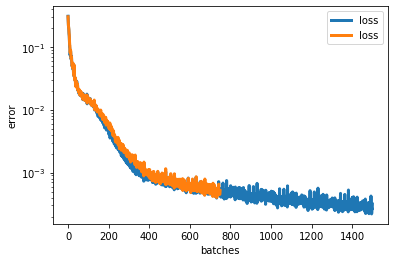

In [28]:
#########################################
#Parameters
learning_rate = 0.001
epochs_s = [200, 300]
minibatch_size = [10, 30]
LRdecay_s = [0.7]
hiddenlayers_s = [[50, 200], [80, 150]] 
layerz = len(hiddenlayers_s)

#########################################
start_time = time.time()
scores = []
index = 0
for e1 in epochs_s:
    for b1 in minibatch_size:
        for d in LRdecay_s:
            for h in hiddenlayers_s:
                class PassiveLearn(nn.Module):

                    def __init__(self, in_sz, out_sz):
                        super(PassiveLearn, self).__init__()

                        self.L_in = nn.Linear(in_sz, h[0])
                        self.H1 = nn.Linear(h[0], h[1])
                        self.H2 = nn.Linear(h[1], out_sz)
                        self.L_out = nn.Linear(out_sz, out_sz)
                        self.Relu = nn.ReLU(inplace=True)
                        self.drop = nn.Dropout(p=0.5)
                    
                    def forward(self, input):
                        x = self.L_in(input)
                        x = self.Relu(x)
                        x = self.H1(x)
                        x = self.Relu(x)
                        x = self.H2(x)
                        x = self.Relu(x)
                        x = self.L_out(x)
                        return x

                model = PassiveLearn(input_size, output_size)

                criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
                #train
                torch.autograd.set_detect_anomaly(True)
                weight_c1 = 1 # p error condition
                batch = np.floor(samplenum_target/b1).astype(int)
                losses= []
                p_smoothness_errors = []
                basic_errors = [] #y_end_ and p_start error
                for e in range(e1):
                    for b in range(batch):
                        loss_batch = 0
                        smoothness_error_batch = 0
                        input_i = data[b*b1:b*b1+b1,:]
                        p_i = p[b*b1:b*b1+b1,:]
                        p_pred = model(input_i)
                        #error claculation
                        loss_batch = weight_c1* criterion(p_pred, p_i)
                        losses.append(loss_batch)
                        optimizer.zero_grad()
                        #Back Prop
                        loss_batch.backward()
                        optimizer.step()
                    scheduler.step()
                    LR= scheduler.get_last_lr()
                    if e%(epochs/10) == 0:
                        print(f'epoch: {e:3}/{e1}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')
                    
                print(f'Model {index} trained')
                print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
                print(f'Training completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed
                


                #Test the data
                #model.eval()
                losses_test= []
                with torch.no_grad():
                    for i in range(samplenum_target_test):
                        p_val = model(input_test[i, :])
                        loss2 = criterion(p_val,p_test[i,:])
                        losses_test.append(loss2.clone().numpy())
                #plot test errors
                plot = plt.plot(losses, label = 'loss', linewidth=3)
                plt.legend()
                plt.yscale('log')
                plt.ylabel('error')
                plt.xlabel('batches')
                plt.savefig(f'../GridSearch_scores/{index}_Loss_.png')
                tot_error = sum(losses_test)
                mean_error = np.mean(losses_test)
                scores.append([index, tot_error, np.double(mean_error), e1, b1, d, h])
                index = index + 1
                print(f'TOTAL ERROR: {tot_error}    mean error: {mean_error}  epochs: {e1}    batchsize: {b1}   LRdecay: {d}  hiddenlayer{h}')
                print("\nNEXT MODEL")
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

In [43]:
with open(f'Gridsearch_scores_vastart_passive_{layerz}2.json', 'w') as outfile:
    json.dump(scores, outfile)